In [ ]:
# function ClickConnect(){
#     console.log("Working");
#     document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
# }
# setInterval(ClickConnect, 30000)

In [ ]:
!nvidia-smi

Tue May 26 12:45:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd drive/"My Drive"/"Colab Notebooks"/master_project/evaluation

/content/drive/My Drive/Colab Notebooks/master_project/evaluation


In [ ]:
%%capture
!pip install simpletransformers==0.28.0
!pip install wandb==0.8.33

In [ ]:
# %%writefile setup.sh
# export CUDA_HOME=/usr/local/cuda-10.1
# git clone https://github.com/NVIDIA/apex
# pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

In [ ]:
# !sh setup.sh

In [ ]:
from simpletransformers.classification import ClassificationModel
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import logging
import pickle
import apex
import numpy as np
import sys 

sys.path.append('..')
from utilities import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Load training and validation data
with open("../HAN/df_all.pkl", "rb") as handle:
    df_all = pickle.load(handle)

training_size = 200000
X_train = df_all.words[df_all["is_which_set"] == "train"][:training_size]
y_train = df_all.categories[df_all["is_which_set"] == "train"][:training_size]

validation_size = 50000
X_val = df_all.words[df_all["is_which_set"] == "val"][:validation_size]
y_val = df_all.categories[df_all["is_which_set"] == "val"][:validation_size]

df_train = pd.DataFrame({"text": X_train, "labels": y_train})
df_val = pd.DataFrame({"text": X_val, "labels": y_val})

              precision    recall  f1-score   support

           0       0.86      0.83      0.85     25330
           1       0.83      0.86      0.85     24670

    accuracy                           0.85     50000
   macro avg       0.85      0.85      0.85     50000
weighted avg       0.85      0.85      0.85     50000



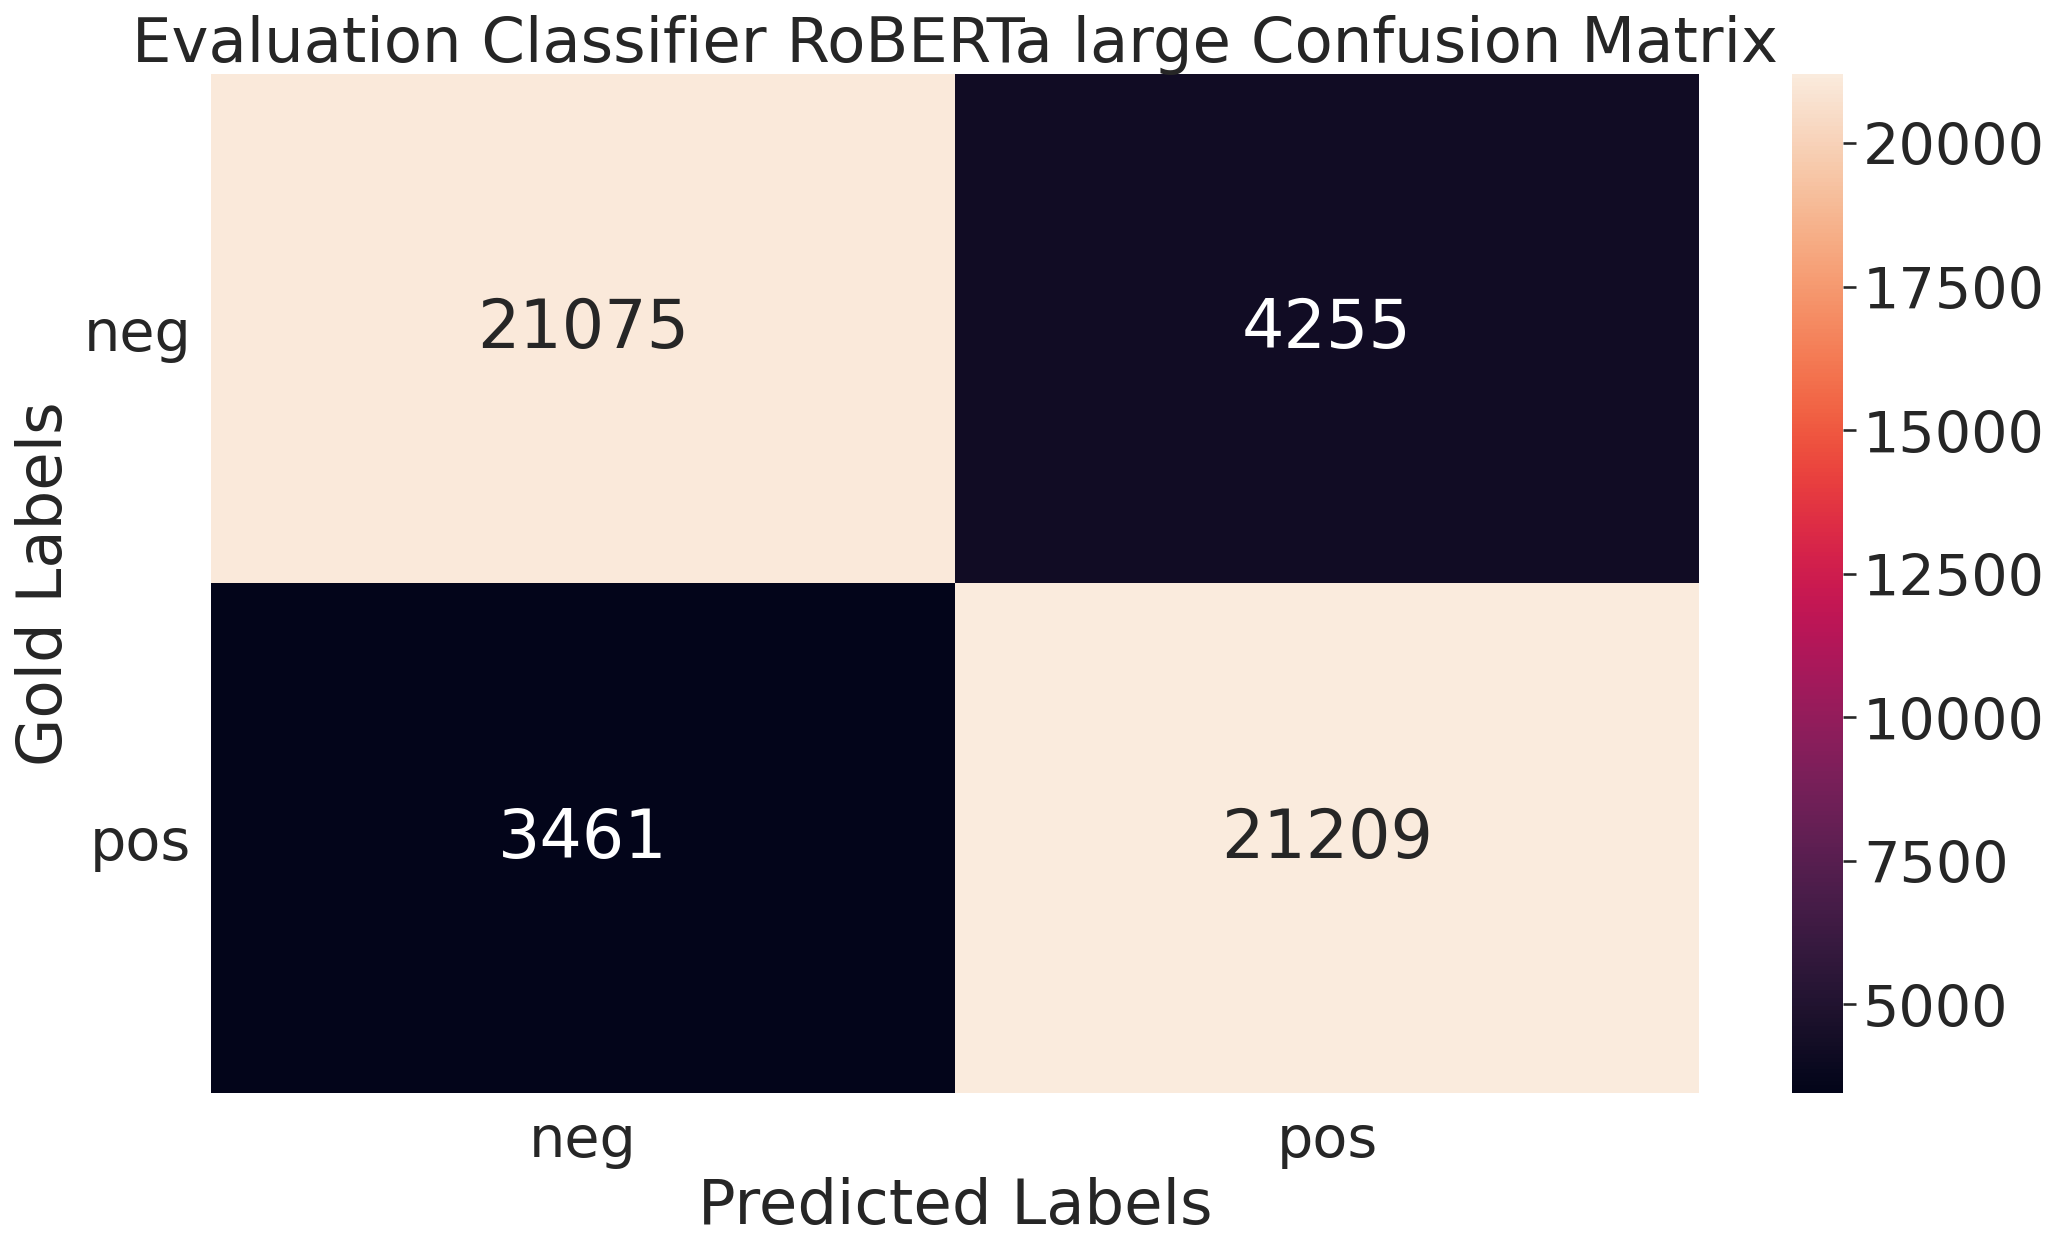

In [ ]:
with open("outputs/roberta_roberta-large_10/results_roberta_roberta-large_10.txt", "r") as f:
    test = []
    for line in f.readlines():
        line = line.strip()
        test.append(int(line))

print(classification_report(y_val, test))
cm = confusion_matrix(y_val, test)
create_confusion_matrix(cm, ["neg", "pos"], show_plots=True, title="Evaluation Classifier RoBERTa large", 
                        xlabel="Predicted Labels", ylabel="Gold Labels", dir="", y_lim_value=2, save_plots=True)

In [ ]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

model_types = ["albert", "bert", "roberta", "distilbert", "xlmroberta"]
model_names = [["albert-base-v2", "albert-large-v2", "albert-xlarge-v2", "albert-xxlarge-v2"], 
               ["bert-base-uncased", "bert-large-uncased"], 
               ["roberta-base", "roberta-large"], 
               ["distilbert-base-uncased"], 
               ["xlm-roberta-base", "xlm-roberta-large"]]

model_type = model_types[2]
model_name = model_names[2][1]

if model_type == "albert":
    is_albert = True
else:
    is_albert = False

epochs = 10

config = {
    "output_dir": "outputs/" + model_type + "_" + model_name + "_" + str(epochs),
    "cache_dir": "cache/" + model_type + "_" + model_name + "_" + str(epochs),
    "best_model_dir": "outputs/" + model_type + "_" + model_name + "_" + str(epochs) + "/best_model/",
    "overwrite_output_dir": True,

    # Added argument, since Albert and XLNet, wandb is bugged
    "is_albert": is_albert,

    "fp16": True,
    "fp16_opt_level": "O1",
    "max_seq_length": 128,
    "train_batch_size": 16,
    "eval_batch_size": 16,
    "num_train_epochs": epochs,
    "learning_rate": 4e-5,
    "adam_epsilon": 1e-8,

    "logging_steps": 20,
    "evaluate_during_training": True,
    "evaluate_during_training_steps": 200,
    "evaluate_during_training_verbose": False,
    "use_cached_eval_features": False,
    "save_eval_checkpoints": False,
    "save_steps": 1000,
    "no_cache": False,
    "save_model_every_epoch": True,

    "use_early_stopping": True,
    "early_stopping_patience": 3,
    "early_stopping_metric": "eval_loss",
    # "wandb_kwargs": {"name":model_type+"_"+model_name + "_" + str(epochs)},
    # "wandb_project": "simple-transformers"
}

# Create a ClassificationModel
model = ClassificationModel(model_type, "outputs/" + model_type + "_" + model_name + "_" + str(epochs), args=config)

In [ ]:
# # Evaluate the model
# result, model_outputs, wrong_predictions = model.eval_model(df_val)

In [ ]:
# y_pred = np.array([np.argmax(probability) for probability in model_outputs])

In [ ]:
# with open("outputs/" + model_type + "_" + model_name + "_" + str(epochs) +"/results_" + model_type + "_" + model_name + "_" + str(epochs) + ".txt", "w") as f:
#     for line in y_pred:
#         f.write(str(line) + "\n")

In [ ]:
# target_names = ['negative', 'positive']
# print(classification_report(y_val, y_pred, target_names=target_names))

In [ ]:
test_sentences = df_all.words[df_all.is_which_set=="test"]

In [ ]:
with open("../sentence_generatedsentence_dict.pickle", "rb") as handle:
    sentence_generatedsentence_dict = pickle.load(handle)

In [ ]:
df_evaluation = pd.DataFrame({
    "OG_sentences": test_sentences,
    "OG_sentiment": [df_all.categories[df_all.words == sentence].values[0] for sentence in test_sentences],
    "GEN_sentences": [sentence_generatedsentence_dict[sentence] for sentence in test_sentences]
})

In [ ]:
gen_sentences = df_evaluation["GEN_sentences"].to_list()

In [ ]:
predictions, raw_outputs = model.predict(gen_sentences)

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


In [ ]:
df_evaluation["GEN_sentiment"] = predictions

In [ ]:
with open("df_evaluation.pickle", "wb") as handle:
    pickle.dump(df_evaluation, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
original = df_evaluation["OG_sentiment"].to_list()
generated = df_evaluation["GEN_sentiment"].to_list()

In [ ]:
from sklearn.metrics import accuracy_score
count = 0
for og, gen in zip(original, generated):
    if og != gen:
        count += 1
print(f"accuracy = {round(count/len(original), 4)*100}")

accuracy = 23.65


In [ ]:
pd.set_option('display.max_colwidth', -1) # show more of pandas dataframe
df_evaluation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,OG_sentences,OG_sentiment,GEN_sentences,GEN_sentiment
699432,i hooked it up according to the quick start manual and it was never able to obtain my guide information,0,i hooked it up according to the lazy start manual and it was never unable to obtain my guide information,0
699434,the right ingredients were definitely put into the music making aspect of the game,0,the right ingredients were definitely put into the music demolition aspect of the game,0
699437,i did not know it was white powder so was surprised to see my very dark hair covered in white powder though it did brush out,0,i did not know it cease black powder so was surprised to see my very dark hair bare in black powder if so it did brush out,0
699442,i love the rainbow light line but bought this product by accident,0,i love the rainbow dark line but bought this product by accident,0
699444,not horrible but not exciting the gameplay is weak,0,not beautiful but exciting the gameplay is weak,0
...,...,...,...,...
799995,the size is just right for a meal,1,the size is unjust right for a meal,1
799996,clean up is a breeze due to the nice slick finish,1,dirty up is a breeze due to the nasty dry finish,1
799997,unfortunately the initial mouse arrived missing the tab that is to be removed to enable squeaking,0,unfortunately the initial mouse arrived missing the tab not that is to be removed to enable deep,0
799998,we have used this in the oven microwave safe freezer and dishwasher,1,we have used this in the oven microwave dangerous freezer and dishwasher,1


In [ ]:
# Accuracy for human evaluation subset
import csv
human_evaluation_subset = []
with open("sheets/style_transfer_intensity.csv", "rt")as f:
    data = csv.reader(f)
    next(data, None)
    for row in data:
        human_evaluation_subset.append(row[0])
len(human_evaluation_subset)

100

In [ ]:
with open("../sentence_generatedsentence_dict.pickle", "rb") as handle:
    df_sent_gensent = pickle.load(handle)
temp_dict = {v: k for k, v in df_sent_gensent.items()}
human_evaluation_subset_og_sent = [temp_dict[sentence] for sentence in human_evaluation_subset]

In [ ]:
human_evaluation_subset_sentiment = []
for sentence in human_evaluation_subset_og_sent:
    human_evaluation_subset_sentiment.append(df_all.categories[df_all.words==sentence].item())

In [ ]:
predictions, raw_outputs = model.predict(human_evaluation_subset_og_sent)

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


In [ ]:
count = 0
count_0_to_1_correct, count_0_to_1_total = 0, 0
count_1_to_0_correct, count_1_to_0_total = 0, 0
for og, gen in zip(human_evaluation_subset_sentiment, predictions):
    if og == 0:
        count_0_to_1_total += 1
    else:
        count_1_to_0_total += 1
    if og != gen:
        count += 1
        if og == 0:
            count_0_to_1_correct += 1
        else:
            count_1_to_0_correct += 1
print(f"accuracy [all] = {round((count/len(human_evaluation_subset_sentiment))*100, 2)}%")
print(f"accuracy [0 -> 1] = {round((count_0_to_1_correct/count_0_to_1_total)*100, 2)}%")
print(f"accuracy [1 -> 0]= {round((count_1_to_0_correct/count_1_to_0_total)*100, 2)}%")

accuracy [all] = 15.0%
accuracy [0 -> 1] = 14.0%
accuracy [1 -> 0]= 16.0%
